# Overview
This notebook aims to explore the dataset and implement a basic (dumb) detection benchmark.
Much of the code here comes from these excellent kernels:
- [Exploratory Data Analysis](https://www.kaggle.com/peterchang77/exploratory-data-analysis)
- [Lung Opacity Overview](https://www.kaggle.com/kmader/lung-opacity-overview/notebook)

## Combine all data into a single table

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pylab
import pandas as pd
from glob import glob
import os.path as op

class_info_path = '../input/stage_1_detailed_class_info.csv'
train_labels_path = '../input/stage_1_train_labels.csv'
images_dir = '../input/stage_1_train_images/'

# data frames
class_info_df = pd.read_csv(class_info_path)
train_labels_df = pd.read_csv(train_labels_path)
images_df = pd.DataFrame({'path': glob(op.join(images_dir, '*.dcm'))})
images_df['patientId'] = images_df['path'].map(lambda x: op.splitext(op.basename(x))[0])
# parse DICOM header into dataframe
DICOM_TAGS = ['PatientAge', 'ViewPosition', 'PatientSex']
def get_tags(image_path):
    tag_data = pydicom.read_file(image_path, stop_before_pixels = True)
    tag_dict = {tag: getattr(tag_data, tag, '') for tag in DICOM_TAGS}
    tag_dict['path'] = image_path
    return pd.Series(tag_dict)
meta_df = images_df.apply(lambda x: get_tags(x['path']), 1)
meta_df['PatientAge'] = meta_df['PatientAge'].map(int)
meta_df.drop('path', 1).describe(exclude=[np.number])

# concatenate the data frames
info_df = pd.concat([class_info_df, train_labels_df.drop('patientId', 1)], 1)
image_with_meta_df = pd.merge(images_df, meta_df, on='path')
bbox_with_info_df = pd.merge(info_df, image_with_meta_df, on='patientId', how='left')

bbox_with_info_df.sample(3)

,patientId,class,x,y,width,height,Target,path,PatientAge,PatientSex,ViewPosition
6992,535c2337-e755-43ea-ab1d-6547a584776d,Normal,NaN,NaN,NaN,NaN,0,../input/stage_1_train_images/535c2337-e755-43...,38,F,PA
9895,6afbb201-ccbb-445f-b3f1-18bc1665f279,Normal,NaN,NaN,NaN,NaN,0,../input/stage_1_train_images/6afbb201-ccbb-44...,45,M,AP
26721,edf1fe7e-46a9-47be-8f65-132b2f8dd56a,Lung Opacity,642.0,368.0,144.0,157.0,1,../input/stage_1_train_images/edf1fe7e-46a9-47...,45,M,PA


## Parse data into a dictionary by patient ID
Keeping the data in the dataframe format makes it easy to compute all sorts of gross statistics, but it is also useful to have a simple way for accessing all the data belonging to a single patient.

In [6]:
def parse_patient_data(df):
    """
    Parse pandas dataframe into the following dictionary:
      data = {
        patientID: {
          'dicom': path/to/dicom/file,
          'target': 0 if normal, 1 if pneumonia,
          'boxes': list of box(es), each box is an array of number [x y width height],
          'class': one of the three values 'Lung Opacity', 'No Lung Opacity / Not Norma', 'Normal',
          'age': age of the patient,
          'view': either 'AP' - anteriorposterior, or 'PA' - posterioranterior,
          'sex': either 'Male' or 'Female'
        },
        ...
      }
    """
    
    extract_box = lambda row: [row['x'], row['y'], row['width'], row['height']]
    
    data = {}
    for n, row in df.iterrows():
        pid = row['patientId']
        if pid not in data:
            data[pid] = {
                'dicom': '%s/%s.dcm' % (images_dir, pid),
                'target': row['Target'],
                'class': row['class'],
                'age': row['PatientAge'],
                'view': row['ViewPosition'],
                'sex': row['PatientSex'],
                'boxes': []}
            
        if data[pid]['target'] == 1:
            data[pid]['boxes'].append(extract_box(row))
    return data

patients_data = parse_patient_data(bbox_with_info_df)
patient_ids = list(patients_data.keys())
print(patients_data[np.random.choice(patient_ids)])

{'dicom': '../input/stage_1_train_images//52f53bb5-81fb-408b-adc7-2f8ae8932b31.dcm', 'target': 0, 'class': 'Normal', 'age': 59, 'view': 'PA', 'sex': 'F', 'boxes': []}


## Visualize patient data
Overlay color boxes of opacities on the original grayscacle DICOM image of a patient.

[[0 1 2 ..., 2 2 2]
 [0 1 2 ..., 2 2 2]
 [0 1 2 ..., 3 3 3]
 ..., 
 [1 3 4 ..., 7 7 7]
 [0 2 3 ..., 5 5 5]
 [0 0 1 ..., 0 0 0]]
255


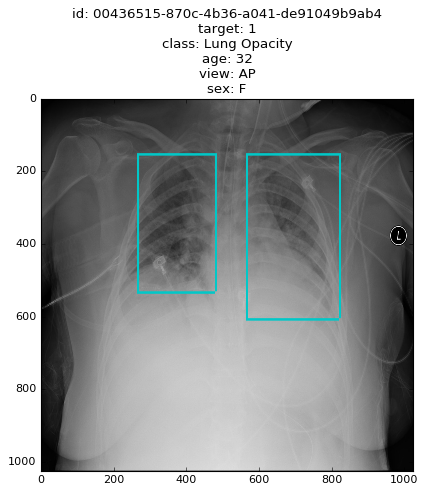

In [14]:
def draw_single_patient(data, mean_image = None):
    """
      Draw a single patient with overalying bounding boxes of opacities (if present)
    """
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array
    
    im = np.stack([im] * 3, axis = 2)
    if (mean_image is np.ndarray):
        im = np.subtract(im, mean_image)
    
    for box in data['boxes']:
        im = overlay_box(im = im, box = box, stroke = 6)
    pylab.imshow(im, cmap = pylab.cm.gist_gray)

def single_patient_info(patient_data, pid):
    patient = patients_data[pid]
    return ('id: %s\ntarget: %s\nclass: %s\nage: %s\nview: %s\nsex: %s' % (pid, patient['target'], patient['class'], patient['age'], patient['view'], patient['sex']))

def overlay_box(im, box, color = [256, 200, 200], stroke = 1):
    """
      Overlay a single box on the image
    """
    
    box = [int(d) for d in box]
    [x1, y1, width, height] = box
    x2 = x1 + width
    y2 = y1 + height
    
    im[y1:y1 + stroke, x1:x2] = color
    im[y2:y2 + stroke, x1:x2] = color
    im[y1:y2, x1:x1 + stroke] = color
    im[y1:y2, x2:x2 + stroke] = color
    
    return im

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

sample_pid = '00436515-870c-4b36-a041-de91049b9ab4'
plt.title(single_patient_info(patients_data, sample_pid))
draw_single_patient(patients_data[sample_pid])

## Data analysis
### Mean image

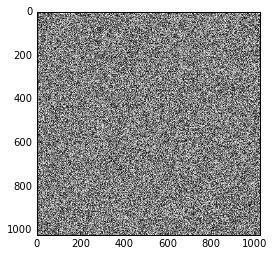

In [8]:
def mean_image(patients_data, pids):
    mean_im = np.zeros((1024, 1024), dtype='uint8')
    
    for pid in pids:
        d = pydicom.read_file(patients_data[pid]['dicom'])
        im = d.pixel_array
        mean_im = np.add(mean_im, im)
    mean_im = np.round(np.multiply(np.divide(mean_im, np.amax(mean_im)), 255)).astype(int)
    mean_im = np.stack([mean_im] * 3, axis = 2)
    return mean_im

global_mean = mean_image(patients_data, patient_ids)
pylab.imshow(global_mean, cmap = pylab.cm.gist_gray)

### AP vs PA

KeyboardInterrupt: 

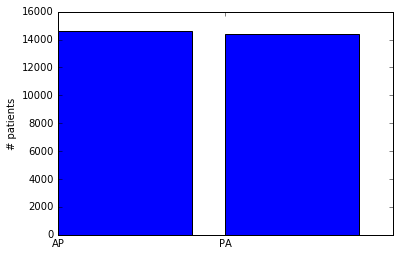

In [10]:
ap_patient_ids = bbox_with_info_df.loc[bbox_with_info_df['ViewPosition'] == 'AP', 'patientId'].values
pa_patient_ids = bbox_with_info_df.loc[bbox_with_info_df['ViewPosition'] == 'PA', 'patientId'].values

fig, ax = plt.subplots()
plt.bar(np.arange(1, 3), list(map(lambda x: x.shape[0], [ap_patient_ids, pa_patient_ids])))
ax.set_ylabel('# patients')
ax.set_xticks(np.arange(1,3))
ax.set_xticklabels(['AP', 'PA'])

mean_ap_img = mean_image(patients_data, ap_patient_ids)
mean_pa_img = mean_image(patients_data, pa_patient_ids)

plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(221)
sample_ap_pid = np.random.choice(ap_patient_ids)
plt.title(single_patient_info(patients_data, sample_ap_pid))
draw_single_patient(patients_data[sample_ap_pid])
plt.subplot(223)
draw_single_patient(patients_data[sample_ap_pid], mean_ap_img)

plt.subplot(222)
sample_pa_pid = np.random.choice(pa_patient_ids)
plt.title(single_patient_info(patients_data, sample_pa_pid))
draw_single_patient(patients_data[sample_pa_pid])
plt.subplot(224)
draw_single_patient(patients_data[sample_pa_pid], mean_pa_img)